<a href="https://colab.research.google.com/github/Rezckant/aImportance_pseudo_labeling/blob/main/pseudo_labeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This notebook addresses the impact of pseudo labeling And how to enhance the accuracy of the models without overfitting them.**
**I worked with this dataset without implementing pseudo labeling and got these scores with the following models.**

*       Model    Accuracy Score
1.                  ETC    -    0.859606
2.         RandomForest    -    0.857143
3.             CatBoost    -    0.839827
4.              XGBoost    -    0.822511
5.                  GBC    -    0.818182
6.                  SVM    -    0.813853
7.                 KNN     -    0.774892
8.   LogisticRegression    -    0.757576
9.           NaiveBayes    -    0.753247

**The implementation of Pseudo Labeling is really simple, the way to implement it is as follows.**
1. **Train model on a batch of labeled data.**
2. **Use the trained model to predict labels on a batch of unlabeled data.**
3. **Use the predicted labels to calculate the loss on unlabeled data.**
4. **Combine labeled loss with unlabeled loss and backpropagate.**

**Let's see if it improves the Accuracy of the models by implementing Pseudo Labeling. (In this nootebook I will use a basic implementation of pseudo labeling and you will not see here the use of MixMatch.)**

In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [69]:
df = pd.read_csv('diabetes.csv')
df.shape

(768, 9)

# EDA

In [70]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [71]:
df_eda = df

In [72]:
df_eda["Glucose"].replace(0, np.nan, inplace=True)
df_eda["BloodPressure"].replace(0, np.nan, inplace=True)
df_eda["SkinThickness"].replace(0, np.nan, inplace=True)
df_eda["Insulin"].replace(0, np.nan, inplace=True)
df_eda["BMI"].replace(0, np.nan, inplace=True)
df_eda.isna().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [73]:
df_eda.isnull().mean().sort_values(ascending=False)

Insulin                     0.486979
SkinThickness               0.295573
BloodPressure               0.045573
BMI                         0.014323
Glucose                     0.006510
Pregnancies                 0.000000
DiabetesPedigreeFunction    0.000000
Age                         0.000000
Outcome                     0.000000
dtype: float64

<Figure size 720x576 with 0 Axes>

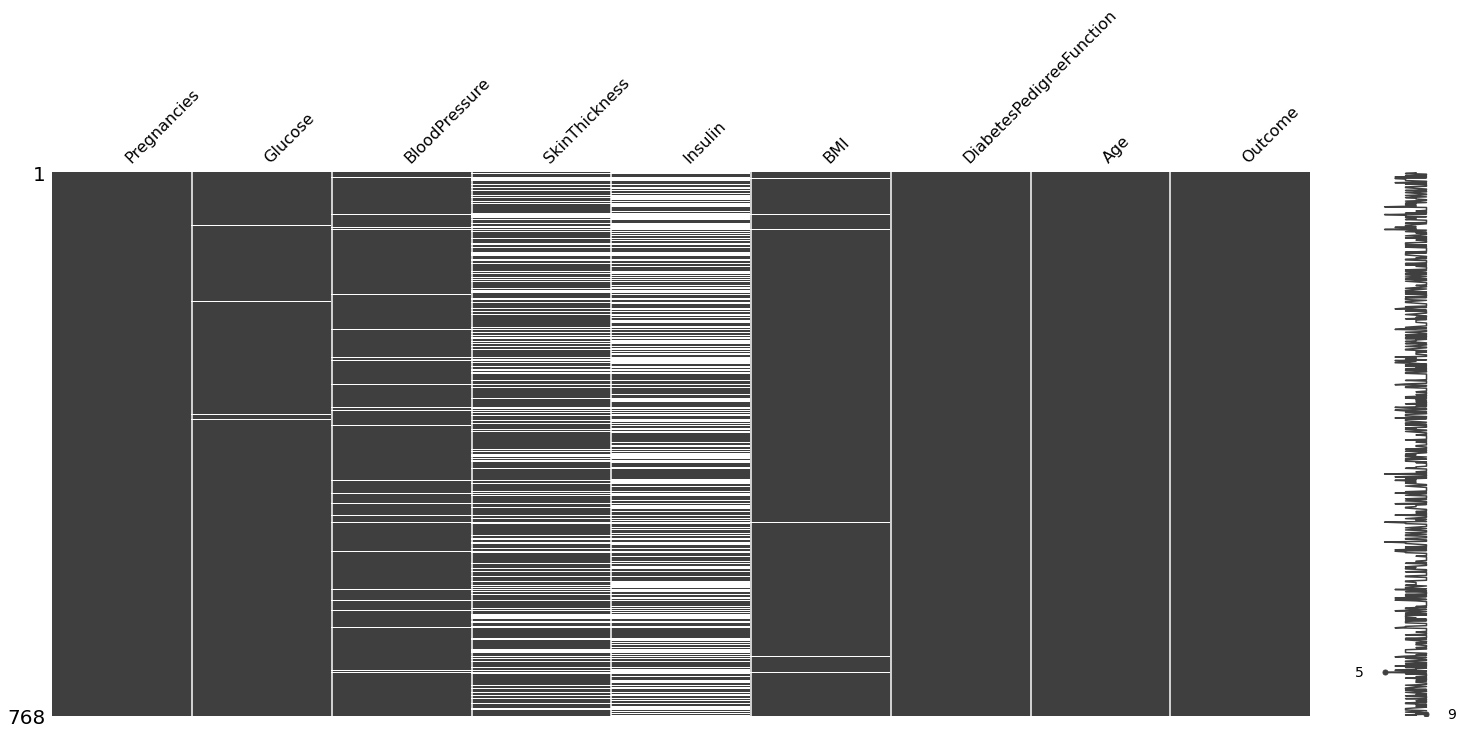

In [74]:
import missingno as msno
plt.figure(figsize = (10,8))
msno.matrix(df_eda)

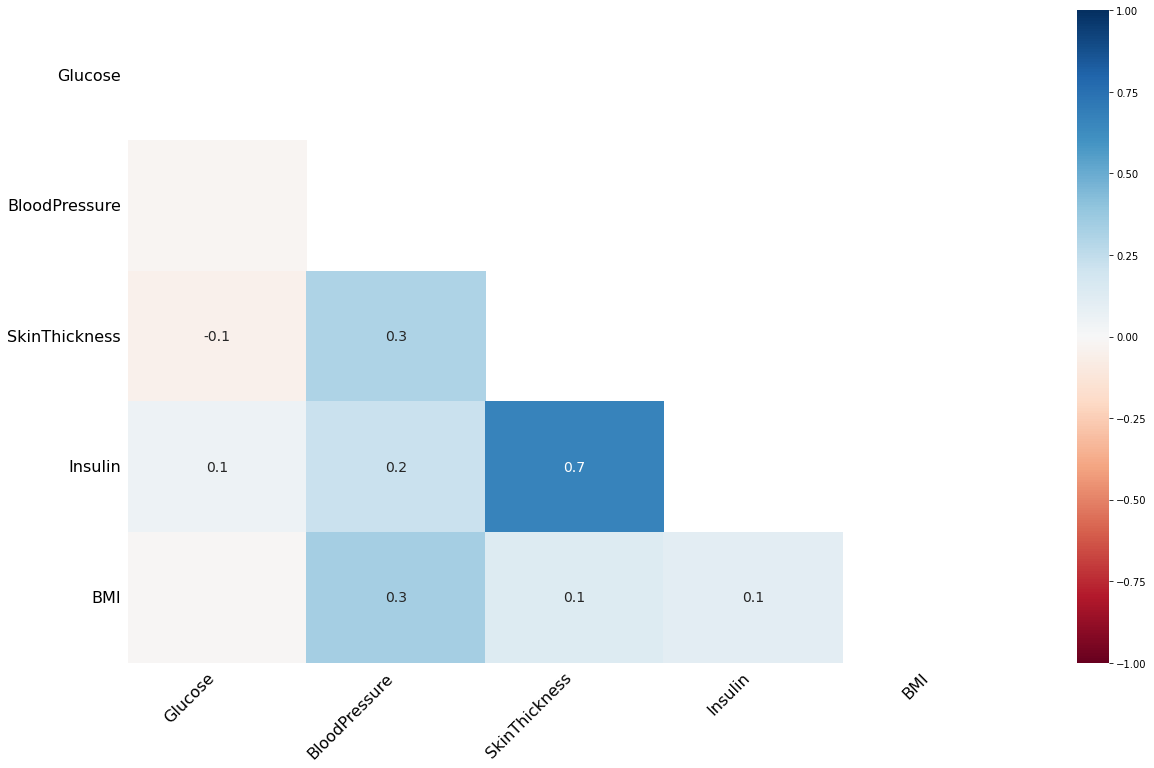

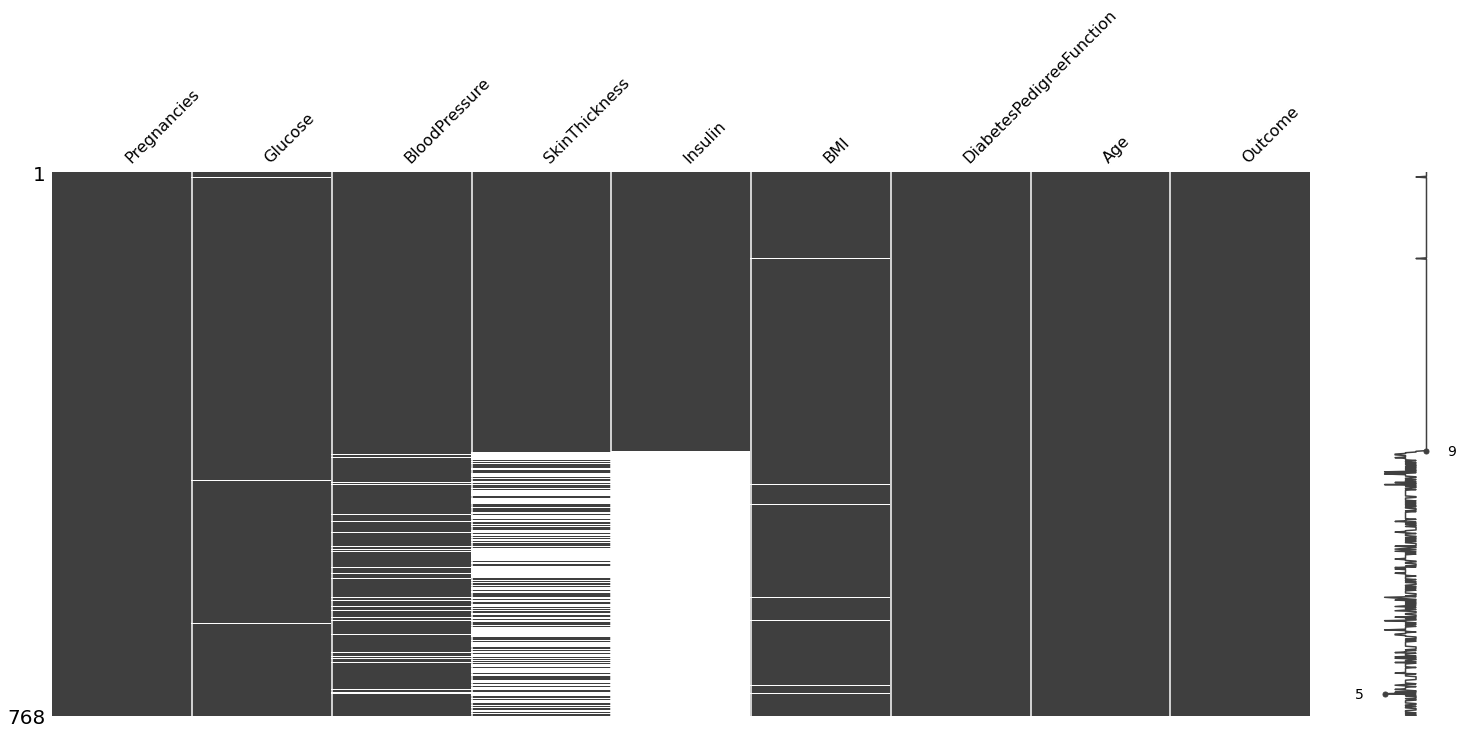

In [75]:
msno.heatmap(df_eda)
msno.matrix(df_eda.sort_values("Insulin"))

## Imputacion** de datos faltantes

In [76]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [77]:
ii_imp = IterativeImputer(estimator=ExtraTreesRegressor(), max_iter=50, random_state= 0)

In [78]:
df_eda.loc[:, :] = ii_imp.fit_transform(df_eda)
df_eda.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

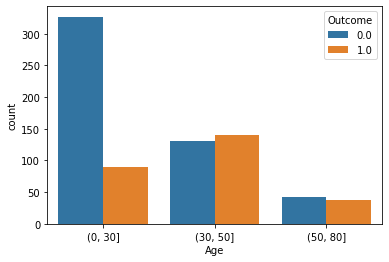

In [79]:
bins=[0,30,50,80]
sns.countplot(x=pd.cut(df.Age, bins=bins), hue=df.Outcome)
plt.show()

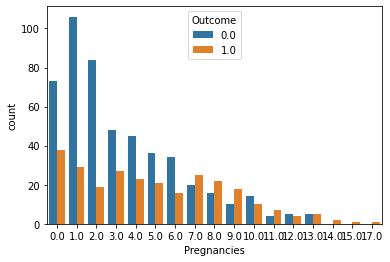

In [80]:
sns.countplot(df.Pregnancies, hue=df.Outcome)
plt.show()

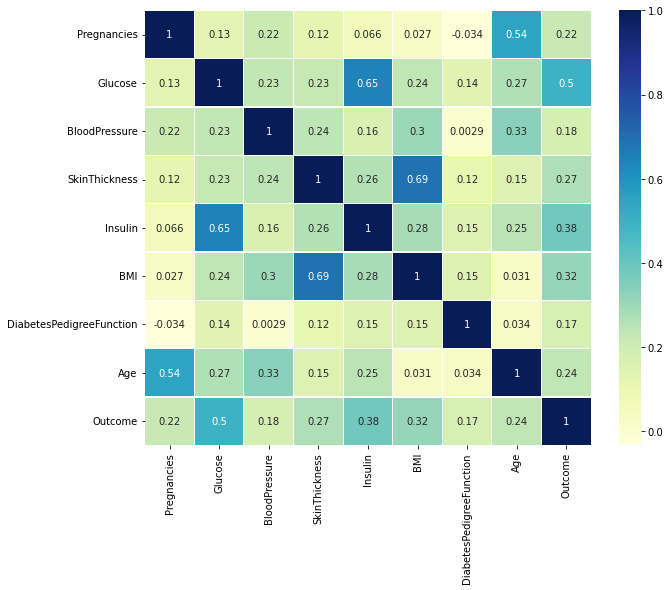

In [81]:
plt.figure(figsize=(10,8))
sns.heatmap(data=df_eda.corr(),cmap="YlGnBu", annot=True ,linewidths=0.2, linecolor='white')
plt.show()

In [82]:
def plot_uni(d):
    f,ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
    sns.histplot(d, kde=True, ax=ax[0])
    ax[0].axvline(d.mean(), color='y', linestyle='--',linewidth=2)
    ax[0].axvline(d.median(), color='r', linestyle='dashed', linewidth=2)
    ax[0].axvline(d.mode()[0],color='g',linestyle='solid',linewidth=2)
    ax[0].legend({'Mean':d.mean(),'Median':d.median(),'Mode':d.mode()})
    
    sns.boxplot(x=d, showmeans=True, ax=ax[1])
    plt.tight_layout()

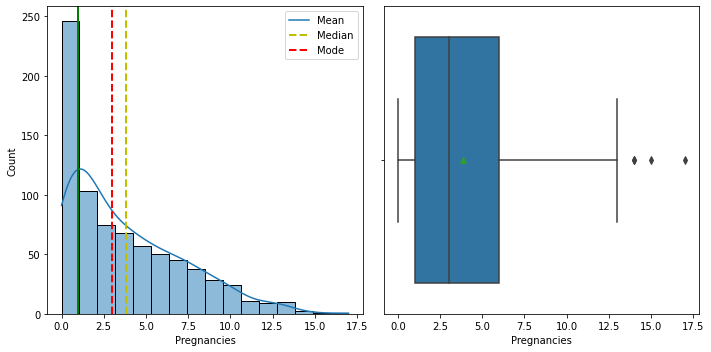

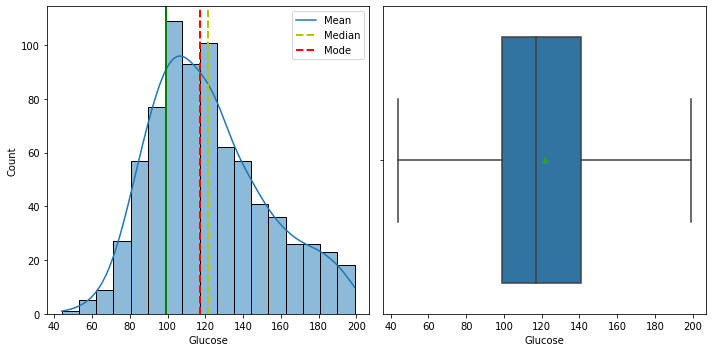

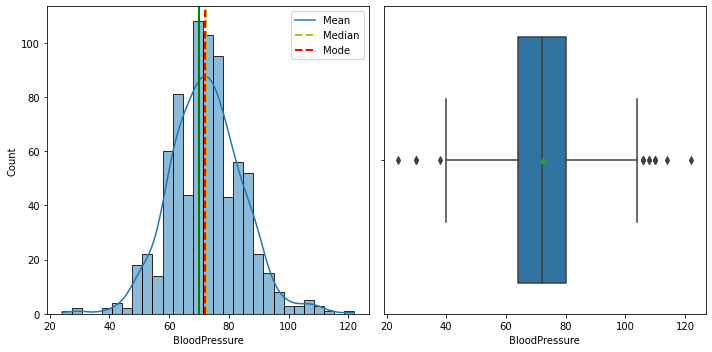

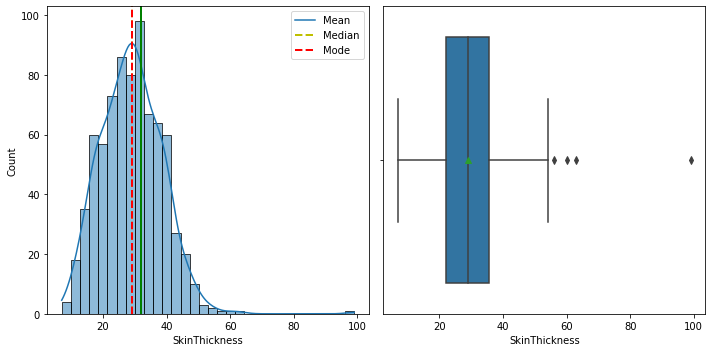

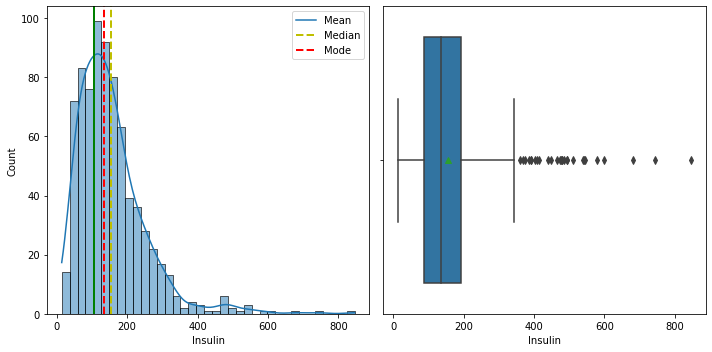

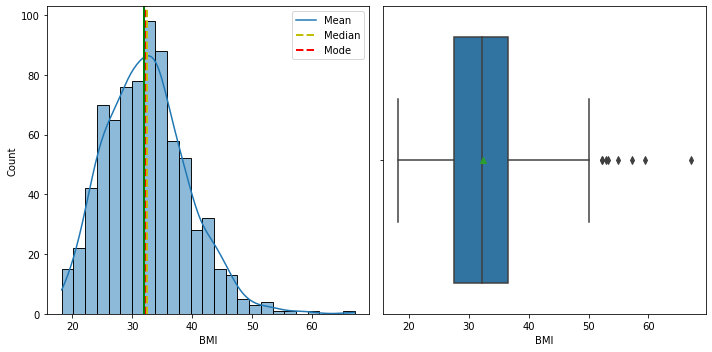

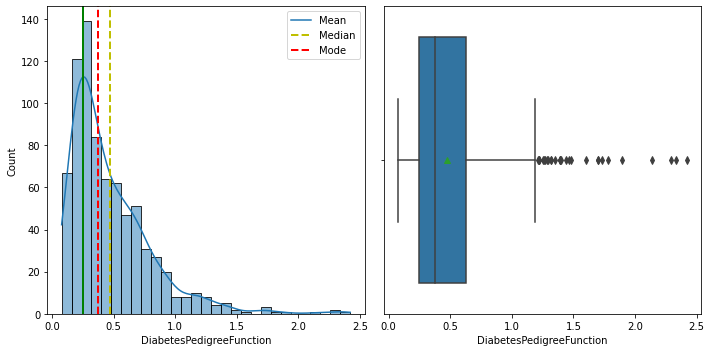

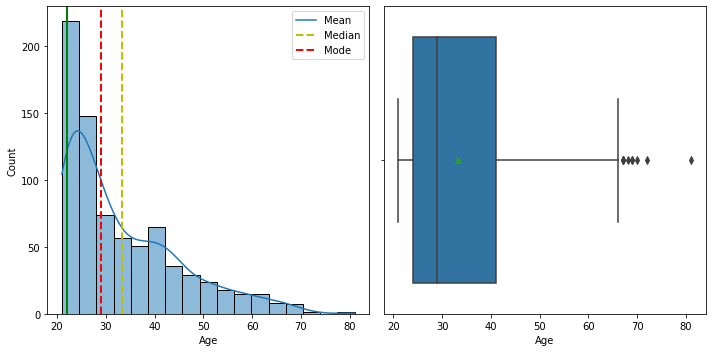

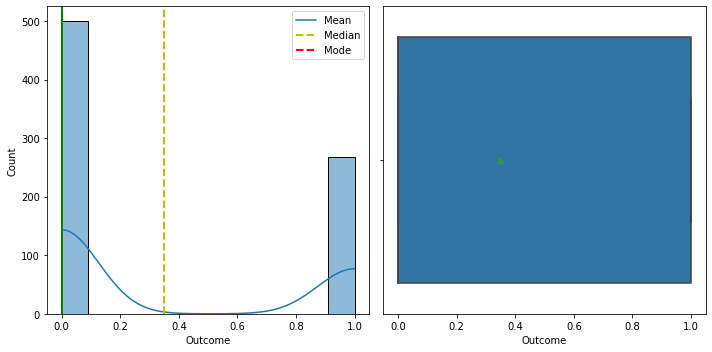

In [83]:
for f in df_eda:
    plot_uni(df[f])

In [84]:
df_skew = pd.DataFrame(data={
    'skewness': df_eda.skew()})
df_skew

,skewness
Pregnancies,0.901674
Glucose,0.533170
BloodPressure,0.144865
SkinThickness,0.657850
Insulin,2.078625
BMI,0.600522
DiabetesPedigreeFunction,1.919911
Age,1.129597
Outcome,0.635017


In [85]:
from sklearn import preprocessing
pt = preprocessing.PowerTransformer()

In [86]:
for col in df_eda.drop(['Outcome'], axis =1).columns:
  df_eda[col] = pt.fit_transform(df_eda[col].values.reshape(-1,1))

In [87]:
df_skew = pd.DataFrame(data={
    'skewness': df_eda.skew()})

In [88]:
df_skew

,skewness
Pregnancies,-0.044644
Glucose,-0.001615
BloodPressure,0.054928
SkinThickness,0.019449
Insulin,0.007080
BMI,-0.000384
DiabetesPedigreeFunction,0.142321
Age,0.150219
Outcome,0.635017


In [89]:
import scipy.stats as stats
z = np.abs(stats.zscore(df_eda))
print(df_eda.shape)

(768, 9)


In [90]:
df_eda = df_eda[(z < 3).all(axis=1)]
print(df_eda.shape)

(753, 9)


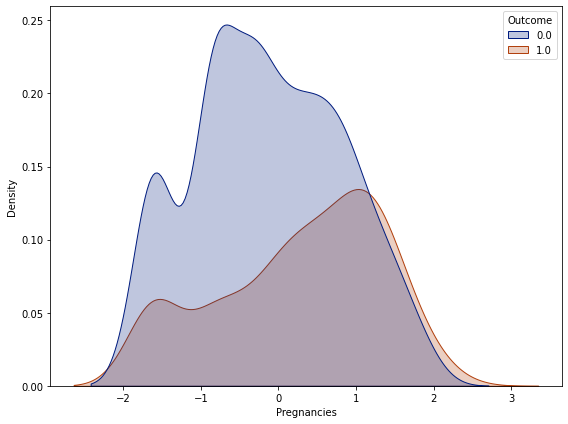

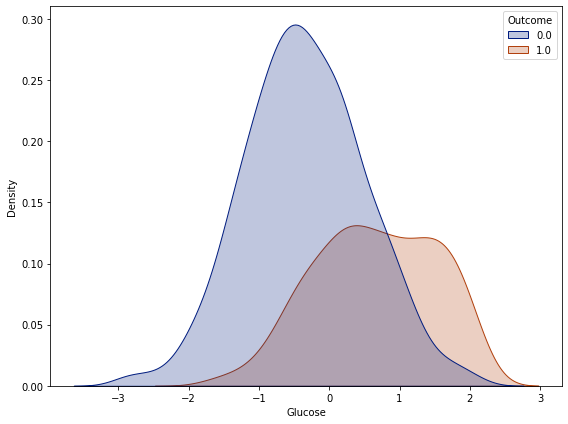

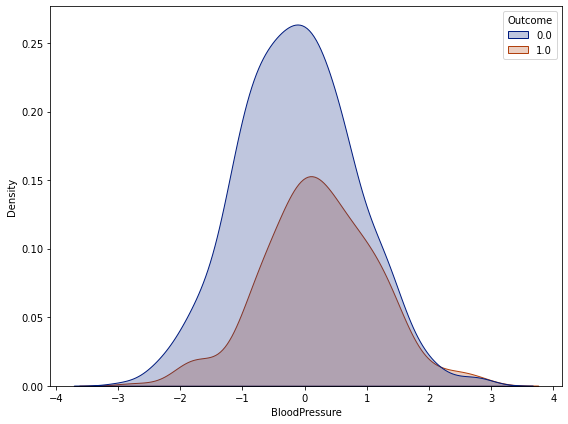

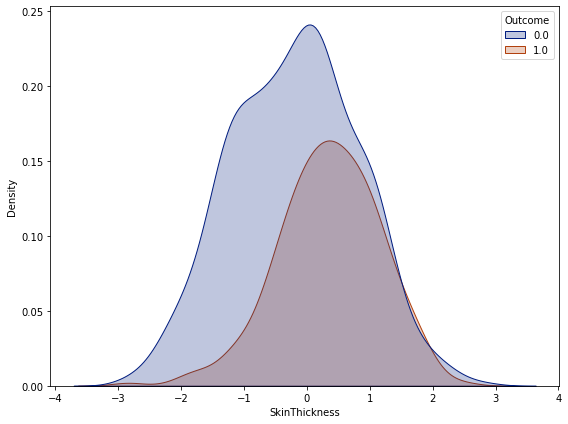

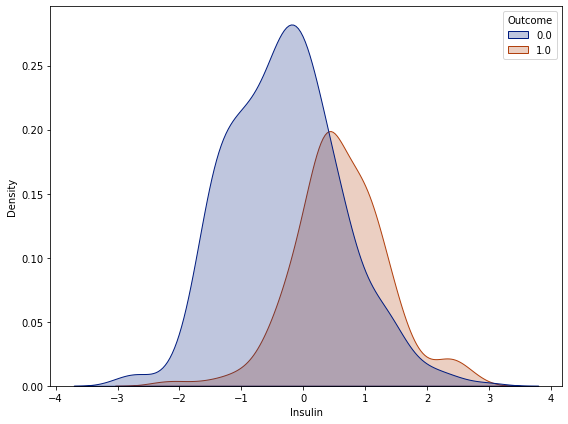

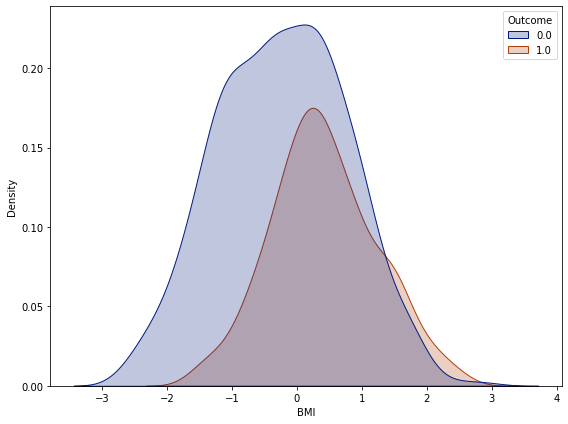

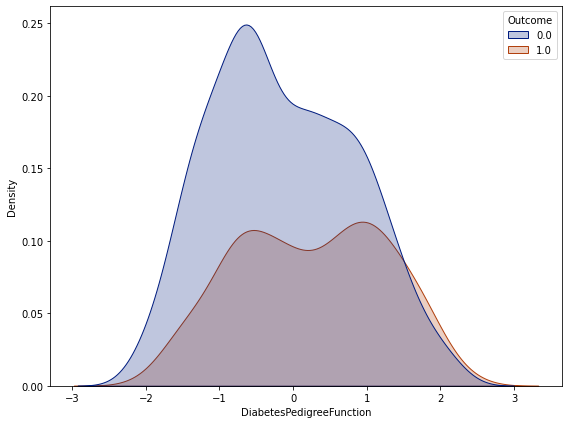

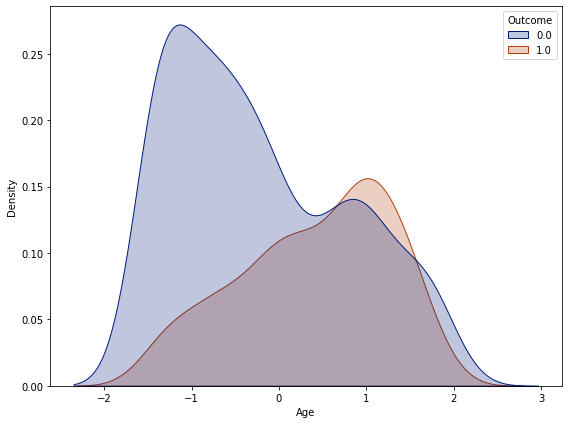

In [91]:
for col in df_eda.drop('Outcome', axis = 1):
  f,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,6))    
  sns.kdeplot(data = df_eda, x = col, hue = 'Outcome', fill = 'dark', palette = 'dark' )
  plt.tight_layout()

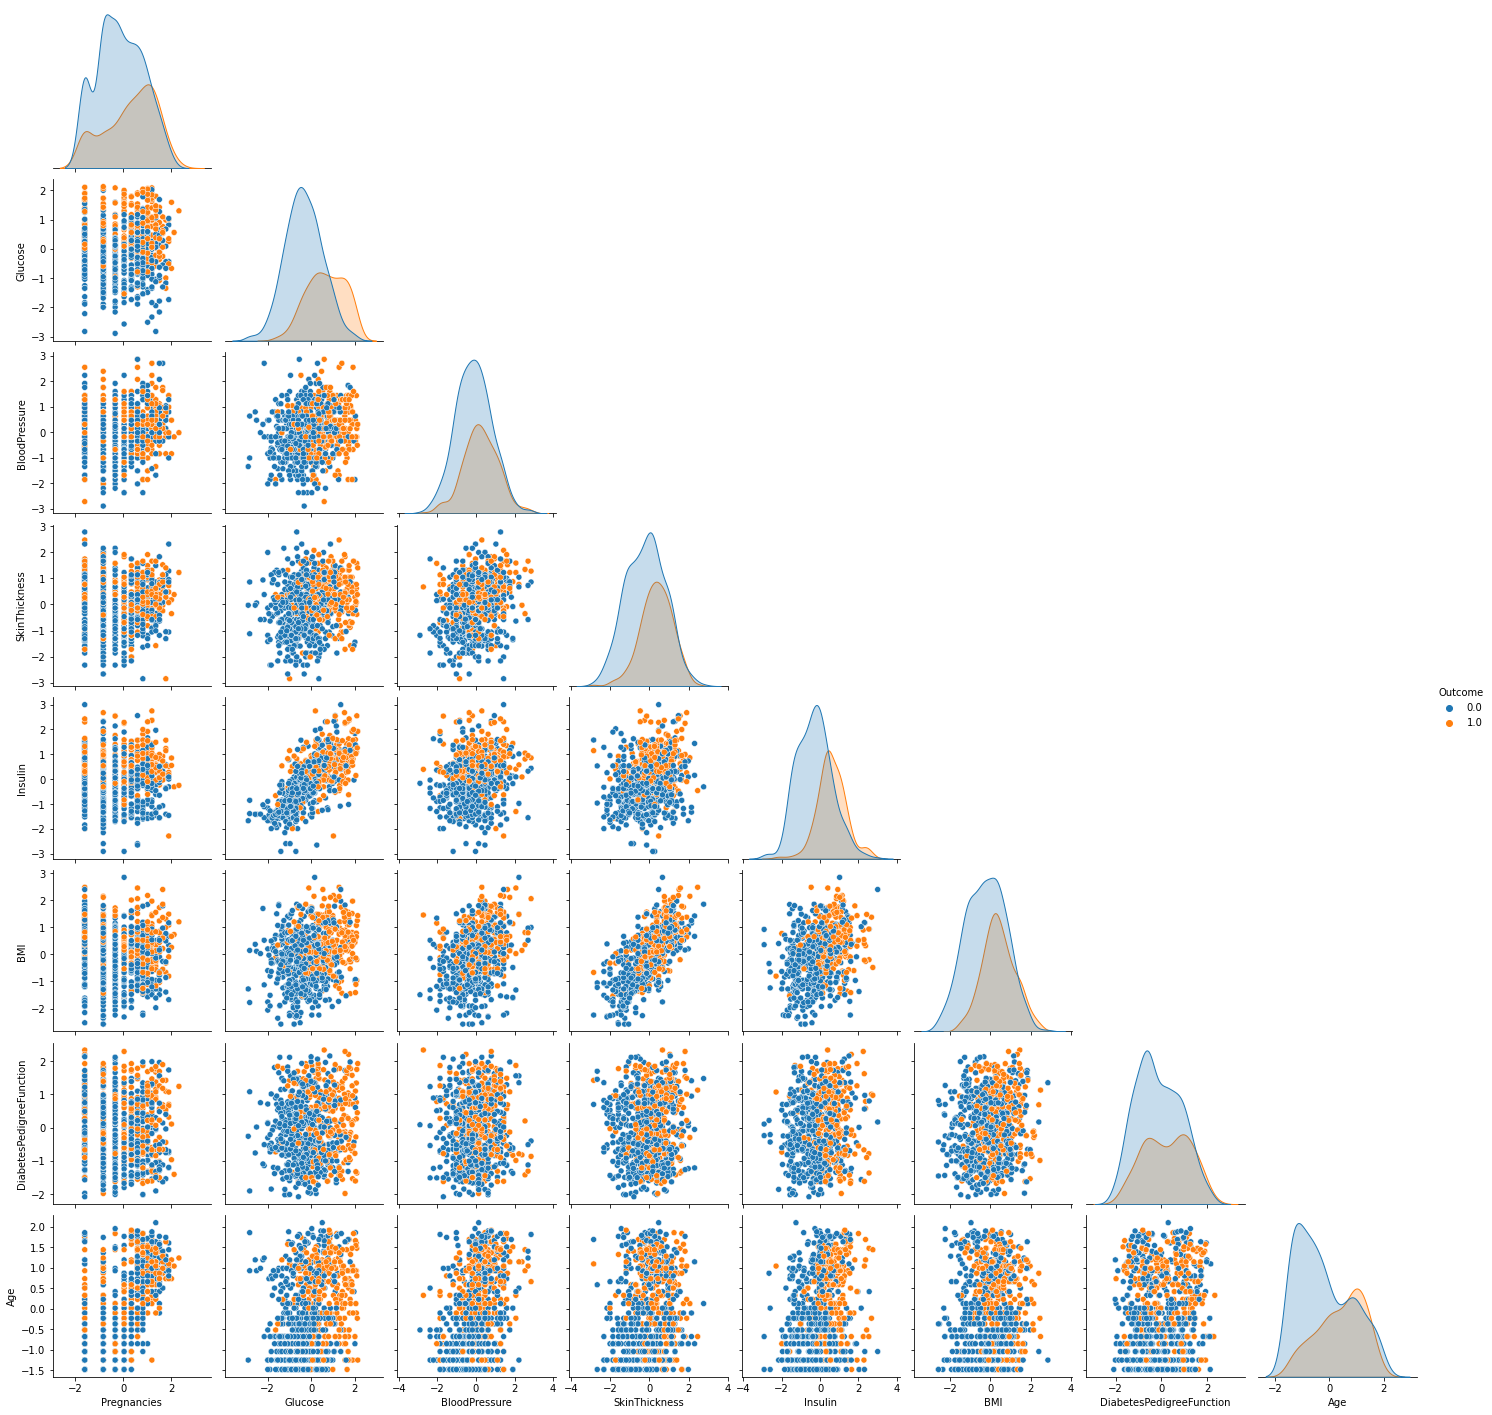

In [92]:
sns.pairplot(df_eda,hue='Outcome',corner=True)

In [93]:
def plot_dis(d):
    f,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,6))   
    sns.boxenplot(x ='Outcome',y = d,  data = df_eda ,palette = 'rainbow')
    plt.tight_layout()

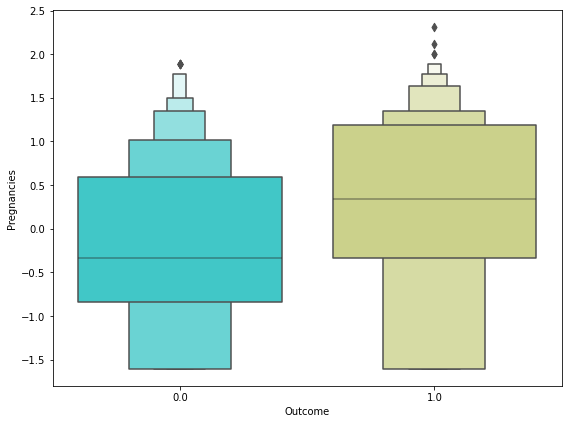

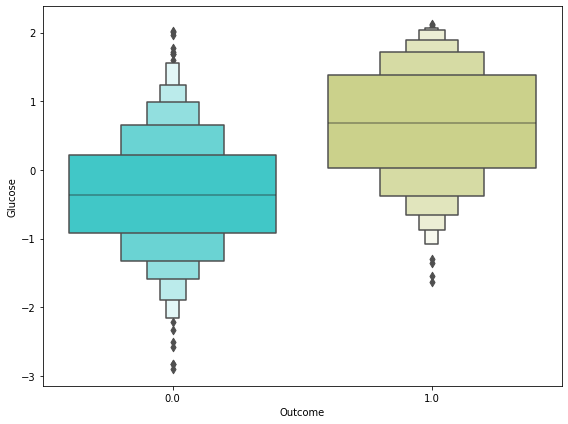

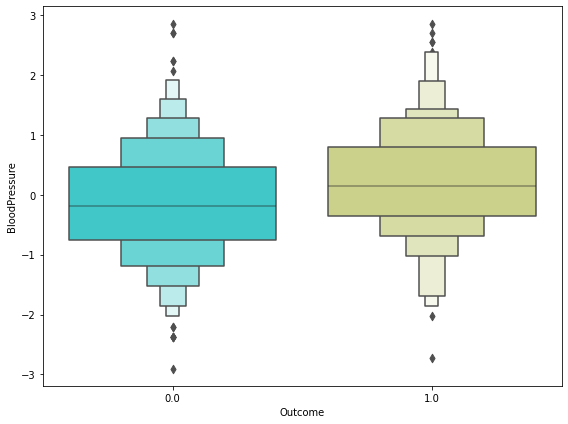

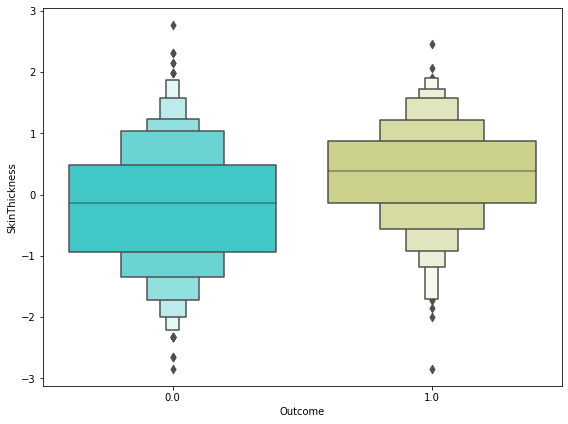

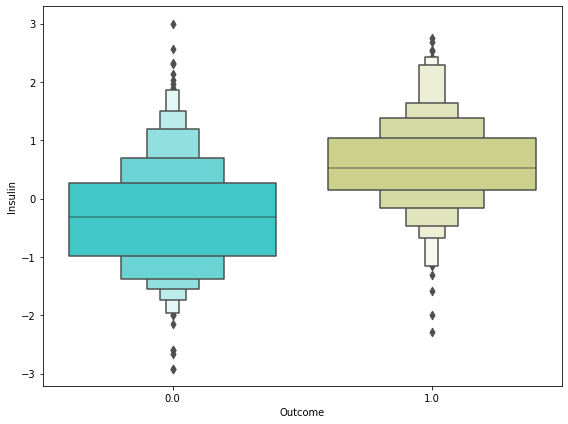

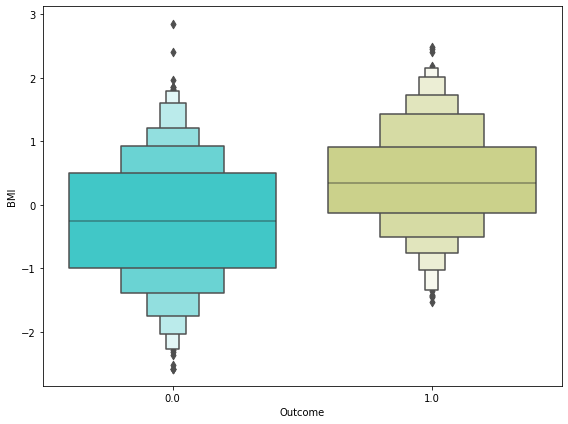

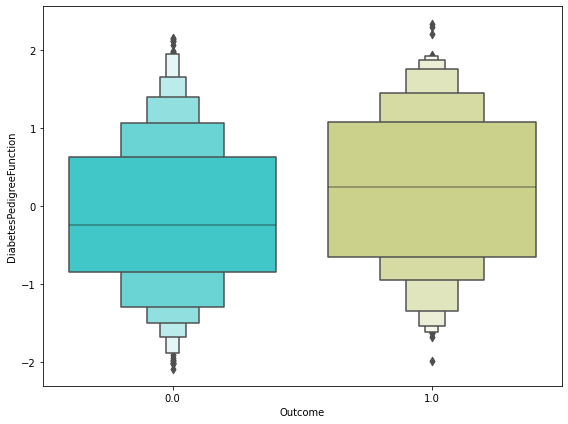

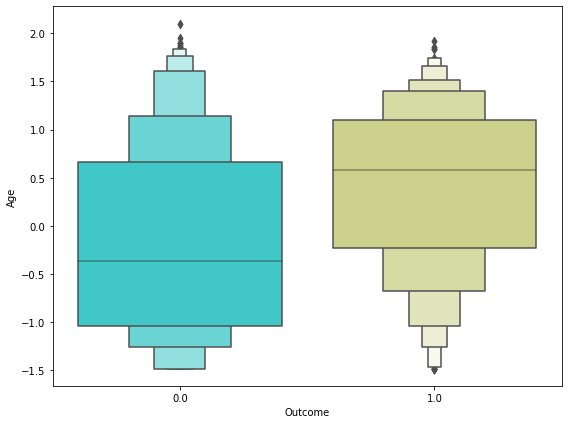

In [94]:
for f in df_eda.drop(['Outcome'], axis =1).columns:
    plot_dis(df_eda[f])

In [95]:
for col in df_eda:
    if col in df_eda.drop('Outcome', axis =1):
        q75,q25 = np.percentile(df_eda.loc[:,col],[75,25])
        iqr = q75-q25
     
        max = q75+(1.5*iqr)
        min = q25-(1.5*iqr)
     
        df_eda.loc[df[col] < min,col] = np.nan
        df_eda.loc[df[col] > max,col] = np.nan
print(df_eda.isna().sum())
df_eda = df_eda.dropna()
print(df_eda.isna().sum())

Pregnancies                  0
Glucose                      3
BloodPressure                7
SkinThickness                3
Insulin                     11
BMI                          1
DiabetesPedigreeFunction     0
Age                          0
Outcome                      0
dtype: int64
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [96]:
import statsmodels.api as sm
def plot_qq(d):
    f,ax = plt.subplots(nrows=1,ncols=2,figsize=(10,8))   
    sns.histplot(d, ax= ax[0])
    ax[0].axvline(d.mean(), color='y', linestyle='--',linewidth=2)
    ax[0].axvline(d.median(), color='r', linestyle='dashed', linewidth=2)
    ax[0].axvline(d.mode()[0],color='g',linestyle='solid',linewidth=2)
    ax[0].legend({'Mean':d.mean(),'Median':d.median(),'Mode':d.mode()})
    sm.qqplot(d, line="s", ax= ax[1], fmt='b')
    ax= ax[1].set_title(col)
    plt.tight_layout()

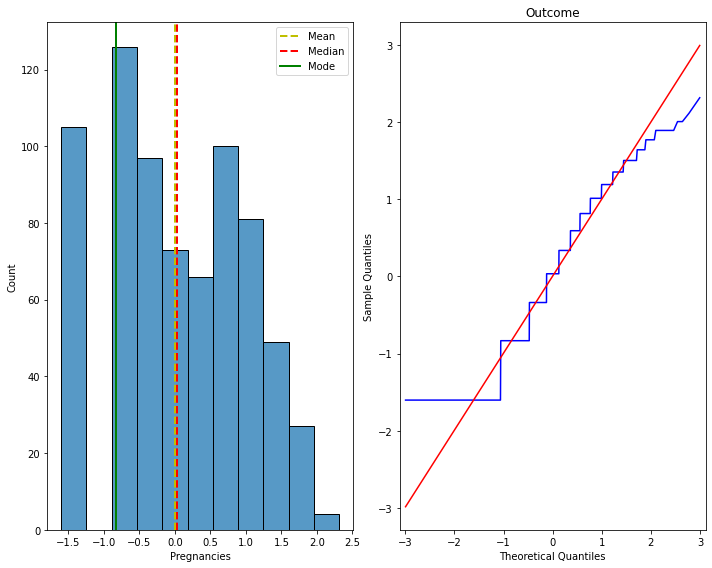

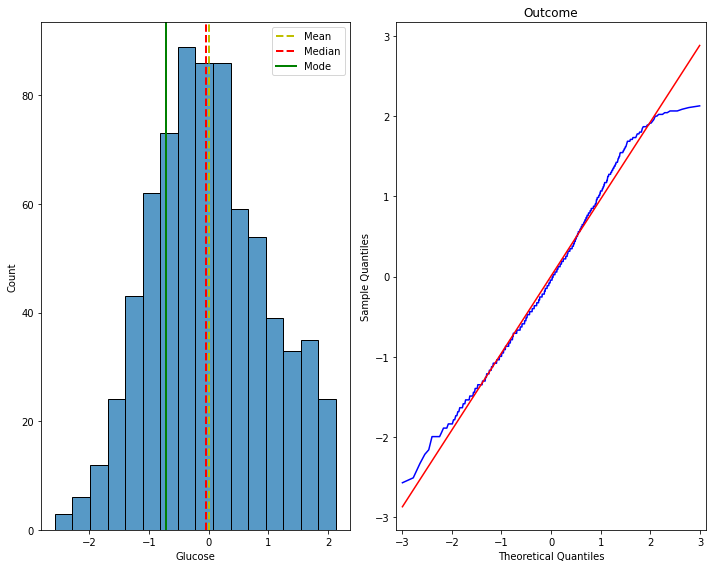

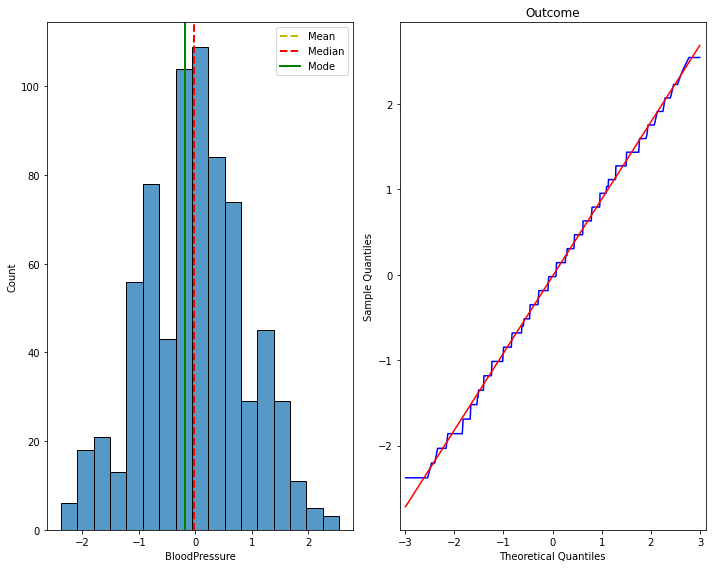

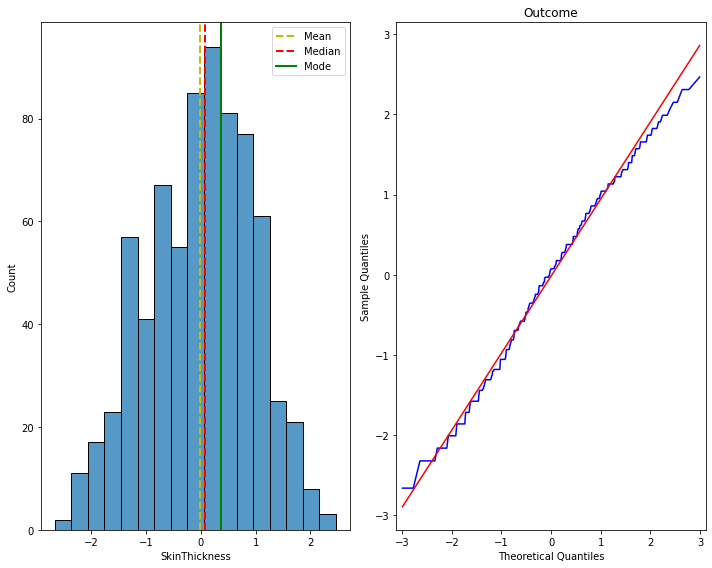

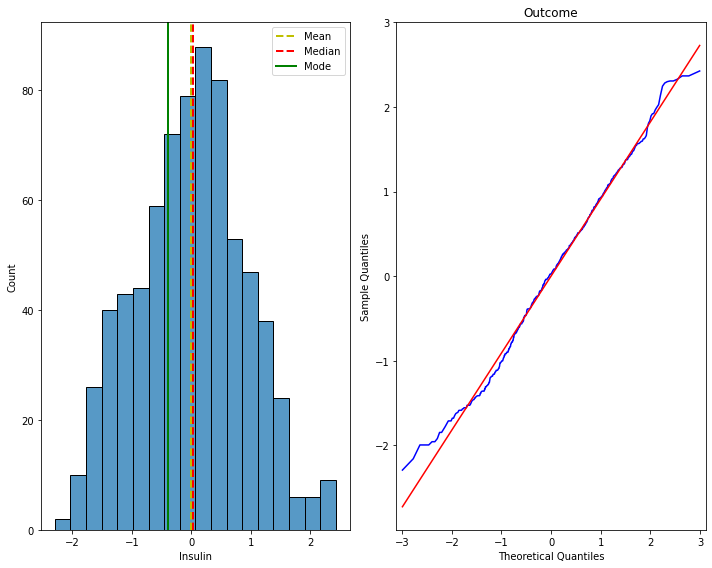

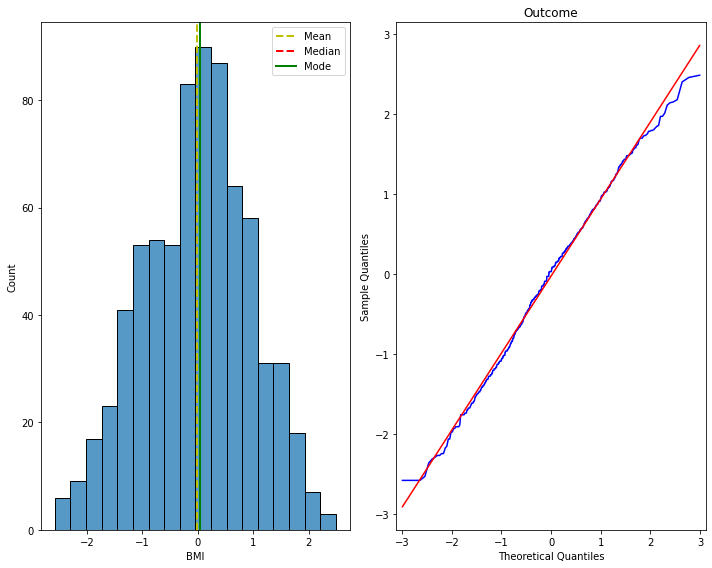

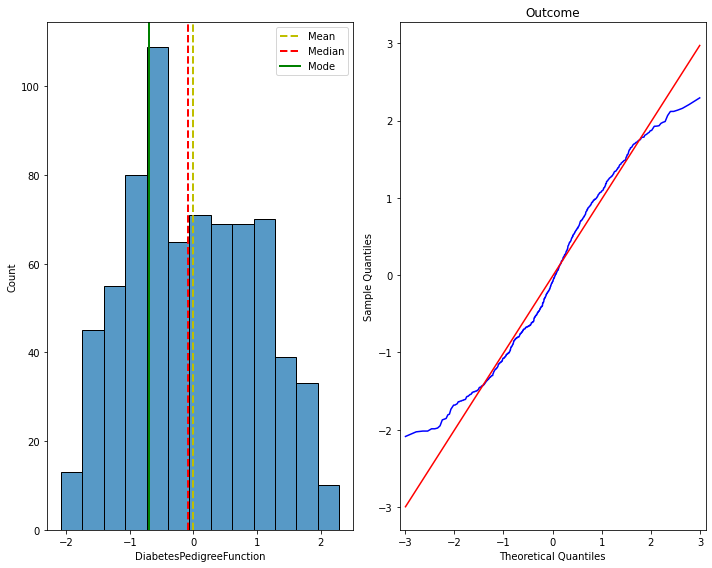

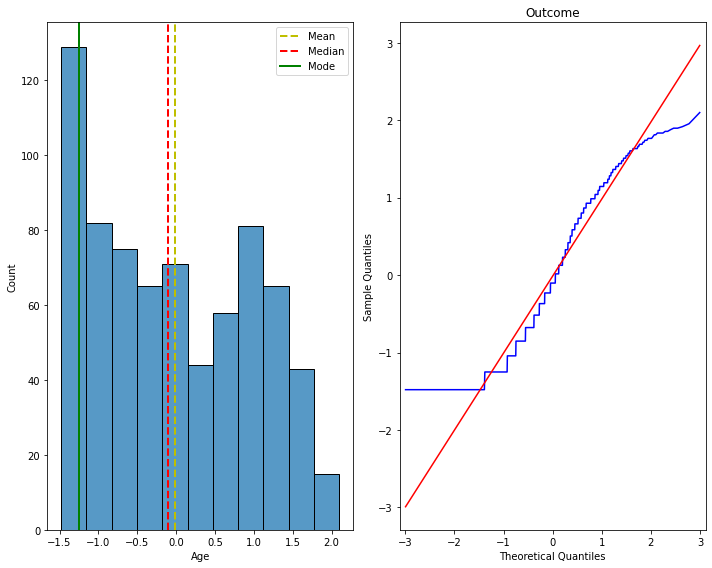

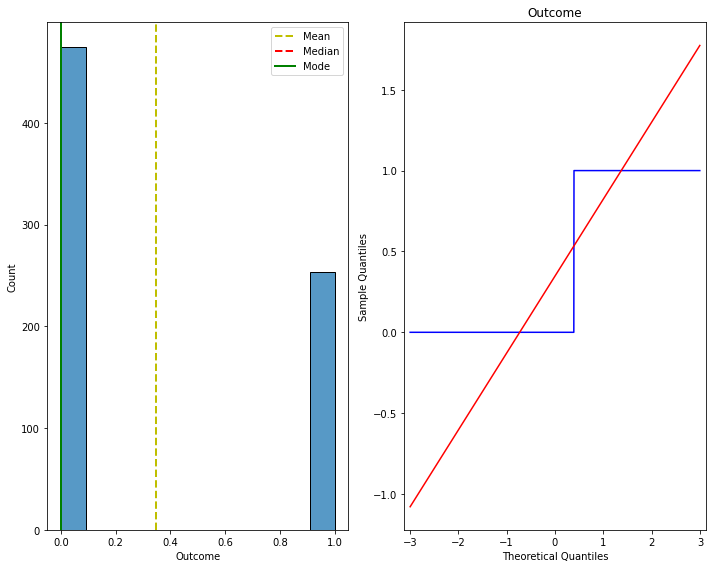

In [97]:
for f in df_eda:
    plot_qq(df_eda[f])

In [98]:
X = df_eda.iloc[:, :-1]
y = df_eda.iloc[:, -1]

In [99]:
from imblearn.combine import SMOTETomek
smk = SMOTETomek(random_state = 15)

In [100]:
print(df_eda.Outcome.value_counts())  
X_res,y_res = smk.fit_resample(X,y)

0.0    475
1.0    253
Name: Outcome, dtype: int64


In [101]:
print(y_res.value_counts())

1.0    459
0.0    459
Name: Outcome, dtype: int64


In [102]:
X = X_res
y = y_res

# Pseudo Labeling

In [103]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,_ = train_test_split(X,y,test_size=.6)
X_train.shape
X_test.shape
y_train.shape

(367,)

In [104]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [105]:
from sklearn.ensemble import RandomForestClassifier
model1 = RandomForestClassifier()
history = model1.fit(X_train,y_train)

In [106]:
model1.score(X_train,y_train)

1.0

In [107]:
y_test = model1.predict(X_test)
y_test.shape

(551,)

In [108]:
X_train = np.concatenate((X_train, X_test))

In [109]:
y_train = np.concatenate((y_train, y_test))

In [110]:
print(X_train.shape)
print(y_train.shape)

(918, 8)
(918,)


# Models

In [111]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
models = pd.DataFrame(columns=["Model","Accuracy Score"])

## Logistic Regression

              precision    recall  f1-score   support

         0.0       0.90      0.91      0.90       277
         1.0       0.90      0.90      0.90       274

    accuracy                           0.90       551
   macro avg       0.90      0.90      0.90       551
weighted avg       0.90      0.90      0.90       551



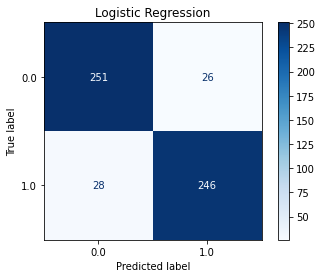

In [112]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(random_state = 0)
log_reg.fit(X_train, y_train)
predictions = log_reg.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, predictions, cmap = plt.cm.Blues)
plt.title('Logistic Regression')
print(classification_report(y_test, predictions))

In [113]:
score = accuracy_score(y_test, predictions)
new_row = {"Model": "LogisticRegression", "Accuracy Score": score}
models = models.append(new_row, ignore_index=True)

## K-Nearest Neighbors

              precision    recall  f1-score   support

         0.0       0.95      0.91      0.93       277
         1.0       0.91      0.96      0.93       274

    accuracy                           0.93       551
   macro avg       0.93      0.93      0.93       551
weighted avg       0.93      0.93      0.93       551



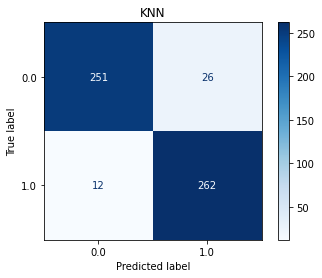

In [114]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 7, metric = 'minkowski', p = 2)
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, predictions, cmap = plt.cm.Blues)
plt.title('KNN')
print(classification_report(y_test, predictions))

In [115]:
score = accuracy_score(y_test, predictions)

new_row = {"Model": "KNN", "Accuracy Score": score}
models = models.append(new_row, ignore_index=True)

## Suport Vector Machine

              precision    recall  f1-score   support

         0.0       0.95      0.94      0.95       277
         1.0       0.94      0.95      0.95       274

    accuracy                           0.95       551
   macro avg       0.95      0.95      0.95       551
weighted avg       0.95      0.95      0.95       551



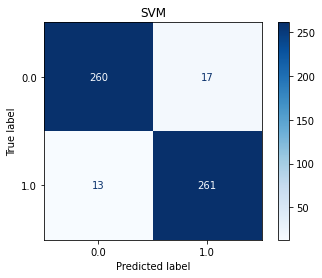

In [116]:
from sklearn.svm import SVC
svm = SVC(kernel = "rbf", random_state = 0)
svm.fit(X_train, y_train) 
predictions = svm.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, predictions, cmap = plt.cm.Blues)
plt.title('SVM')
print(classification_report(y_test, predictions))

In [117]:
score = accuracy_score(y_test, predictions)
new_row = {"Model": "SVM", "Accuracy Score": score}
models = models.append(new_row, ignore_index=True)

## Naive bayes

              precision    recall  f1-score   support

         0.0       0.93      0.87      0.90       277
         1.0       0.87      0.94      0.90       274

    accuracy                           0.90       551
   macro avg       0.90      0.90      0.90       551
weighted avg       0.90      0.90      0.90       551



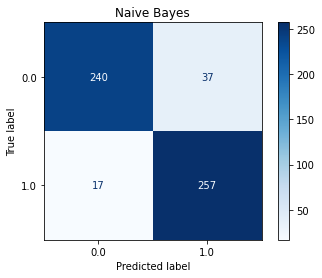

In [118]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train, y_train)
predictions = nb.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, predictions, cmap = plt.cm.Blues)
plt.title('Naive Bayes')
print(classification_report(y_test, predictions))

In [119]:
score = accuracy_score(y_test, predictions)
new_row = {"Model": "NaiveBayes", "Accuracy Score": score}
models = models.append(new_row, ignore_index=True)

## Random Forest

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       277
         1.0       1.00      1.00      1.00       274

    accuracy                           1.00       551
   macro avg       1.00      1.00      1.00       551
weighted avg       1.00      1.00      1.00       551



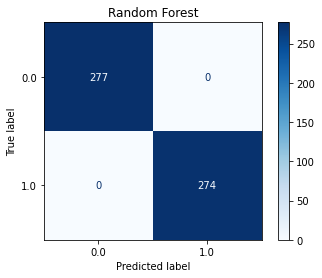

In [120]:
from sklearn.ensemble import RandomForestClassifier
randomforest = RandomForestClassifier(n_estimators = 200, criterion = "gini", random_state = 0)
randomforest.fit(X_train, y_train)
predictions = randomforest.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, predictions, cmap = plt.cm.Blues)
plt.title('Random Forest')
print(classification_report(y_test, predictions))

**This may look suspicious, but the model behaved well with the test set, so there is no reason to think that this is an overfiting.**

**We will see later that this is not an overfitting by means of cross-validation.**

In [121]:
score = accuracy_score(y_test, predictions)
new_row = {"Model": "RandomForest", "Accuracy Score": score}
models = models.append(new_row, ignore_index=True)

## XGBoost

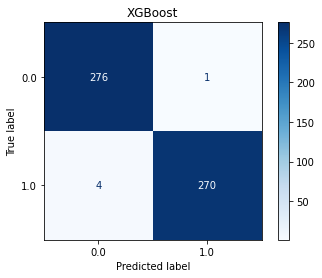

In [122]:
from xgboost import XGBClassifier
XGB = XGBClassifier()
XGB.fit(X_train, y_train)
predictions = XGB.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, predictions, cmap = plt.cm.Blues)
plt.title('XGBoost')
report = (classification_report(y_test, predictions))

In [123]:
score = accuracy_score(y_test, predictions)

new_row = {"Model": "XGBoost", "Accuracy Score": score}
models = models.append(new_row, ignore_index=True)

## CatBoost

In [124]:
!pip install catboost

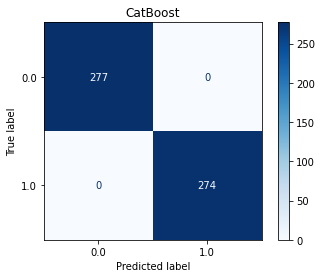

In [125]:
from catboost import CatBoostClassifier
CatBoost = CatBoostClassifier(verbose=False)
CatBoost.fit(X_train,y_train,eval_set=(X_test, y_test))
predictions = CatBoost.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, predictions, cmap = plt.cm.Blues)
plt.title('CatBoost')
report = (classification_report(y_test, predictions))

In [126]:
score = accuracy_score(y_test, predictions)

new_row = {"Model": "CatBoost", "Accuracy Score": score}
models = models.append(new_row, ignore_index=True)

## ExtraTreeClassifier

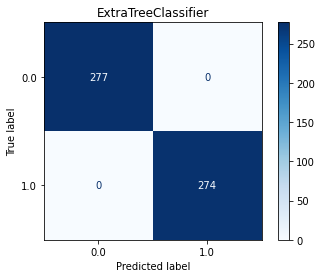

In [127]:
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier(n_estimators = 200,
                                        criterion ='entropy', max_features = 'auto')
etc.fit(X_train,y_train)
predictions = etc.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, predictions, cmap = plt.cm.Blues)
plt.title('ExtraTreeClassifier')
report = (classification_report(y_test, predictions))

In [128]:
score = accuracy_score(y_test, predictions)

new_row = {"Model": "ETC", "Accuracy Score": score}
models = models.append(new_row, ignore_index=True)

## GradientBoostingClassifier

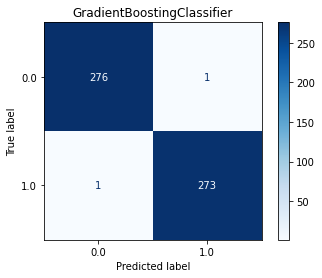

In [129]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train,y_train)
predictions = gbc.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, predictions, cmap = plt.cm.Blues)
plt.title('GradientBoostingClassifier')
report = (classification_report(y_test, predictions))

In [130]:
score = accuracy_score(y_test, predictions)
new_row = {"Model": "GBC", "Accuracy Score": score}
models = models.append(new_row, ignore_index=True)

In [131]:
models.sort_values(by="Accuracy Score", ascending=False)

,Model,Accuracy Score
4,RandomForest,1.000000
6,CatBoost,1.000000
7,ETC,1.000000
8,GBC,0.996370
5,XGBoost,0.990926
2,SVM,0.945554
1,KNN,0.931034
0,LogisticRegression,0.901996
3,NaiveBayes,0.901996


In [135]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = randomforest, X = X_train, y = y_train, cv = 10)
print(accuracies)
print(accuracies.mean()) # Sesgo
print(accuracies.std()) # Varianza

[0.85869565 0.83695652 0.85869565 0.85869565 0.93478261 0.92391304
 0.94565217 0.94565217 0.97802198 0.95604396]
0.9097109412326804
0.048298926849940055


### In conclusion, pseudo-Labeling is a fantastic technique if you want to win Kaggle competitions, but useless in real life. Thank You for reading.